In [1]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
import os
import cv2
from tensorflow.keras.applications.inception_v3 import InceptionV3
import imageio
import skimage
import skimage.io
import skimage.transform
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

In [ ]:
os.listdir('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5')[:5]

In [3]:
patients = os.listdir('../input/breast-histopathology-images/IDC_regular_ps50_idx5')

len(patients)

279

In [4]:
images = 'images'
os.mkdir(images)

In [5]:
# received help from https://docs.python.org/3/library/shutil.html and https://www.tutorialspoint.com/python/os_listdir.htm
#create a list for patients 
patient_list = os.listdir('./IDC_regular_ps50_idx5')
for patient in patient_list:
    #create a path variable for positive and negative images
    negative_images = './IDC_regular_ps50_idx5/' + str(patient) + '/0'
    positive_images = './IDC_regular_ps50_idx5/' + str(patient) + '/1'


    # create a list of all files in folders that end in 0
    neg_list = os.listdir(negative_images)
    # create a list of list all files in folders that end in 1
    pos_list = os.listdir(positive_images)
    #shutil.copyfile(src, dst, *, follow_symlinks=True) --- example of format
    #Copy the contents of the file named src to a file named dst and return dst in the most efficient way possible.
    # move the negative images to images
    for filename in neg_list:

        # source path to image
        src = os.path.join(negative_images, filename)
        # destination path to image
        dst = os.path.join(images, filename)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


    # move the positive images to images
    for filename in pos_list:

        # source path to image
        src = os.path.join(positive_images, filename)
        # destination path to image
        dst = os.path.join(images, filename)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [6]:
len(os.listdir('images'))

277524

In [7]:
image_list = os.listdir('images')
df_idc = pd.DataFrame(image_list, columns=['image_id'])
df_idc.head()

,image_id
0,12878_idx5_x601_y1401_class0.png
1,9176_idx5_x1851_y801_class0.png
2,9225_idx5_x501_y601_class0.png
3,9125_idx5_x1251_y1351_class1.png
4,14153_idx5_x3051_y2851_class0.png


In [8]:
# append patient ID and target information to df
# there are 5 parts to each image id that can be separated on _ 
def get_patient_id(x):
    # split into a list
    i = x.split('_')
    # the id is the first index in the list
    patient_id = i[0]
    
    return patient_id

def get_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in the 4th index
    b = a[4]
    # the y target 0 or 1 is the 5th index of the string 
    target = b[5]
    
    return target

# extract the patient id

# create a new column called 'patient_id' and apply the patient id function 
df_idc['patient_id'] = df_idc['image_id'].apply(get_patient_id)
# create a new column called 'target' and apply the patient's target variable 
df_idc['target'] = df_idc['image_id'].apply(get_target)

df_idc.head()

,image_id,patient_id,target
0,12878_idx5_x601_y1401_class0.png,12878,0
1,9176_idx5_x1851_y801_class0.png,9176,0
2,9225_idx5_x501_y601_class0.png,9225,0
3,9125_idx5_x1251_y1351_class1.png,9125,1
4,14153_idx5_x3051_y2851_class0.png,14153,0


In [ ]:
df_idc.shape

In [ ]:
df_idc['target'].value_counts()

In [11]:
# take a sample of class 0 to match class 1 (total = 78786)
df_0 = df_idc[df_idc['target'] == '0'].sample(78786, random_state=1984)
df_1 = df_idc[df_idc['target'] == '1'].sample(78786, random_state=1984)

# concat to a new dataframe
df_idc = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# ensure class balance 
df_idc['target'].value_counts()

1    78786
0    78786
Name: target, dtype: int64

In [12]:
# train test split 
y = df_idc['target']

df_train, df_val = train_test_split(df_idc, test_size=0.10, random_state=1984)

print(df_train.shape)
print(df_val.shape)

(141814, 3)
(15758, 3)


In [13]:
df_train['target'].value_counts()

1    70915
0    70899
Name: target, dtype: int64

In [14]:
df_val['target'].value_counts()

0    7887
1    7871
Name: target, dtype: int64

In [15]:
# Create a base directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_idc = os.path.join(train_dir, 'no_idc')
os.mkdir(no_idc)
has_idc = os.path.join(train_dir, 'has_idc')
os.mkdir(has_idc)


# create new folders inside val_dir
no_idc = os.path.join(val_dir, 'no_idc')
os.mkdir(no_idc)
has_idc = os.path.join(val_dir, 'has_idc')
os.mkdir(has_idc)

In [ ]:
os.listdir('base_dir/train_dir')

In [16]:
df_idc.set_index('image_id', inplace=True)

In [17]:
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
# Transfer the train images
for image in train_list:
    
    fname = image
    # get target label for each image
    target = df_idc.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'no_idc'
    if target == '1':
        label = 'has_idc'
    
    # source path to image
    src = os.path.join(images, fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)
    

# Transfer the val images

for image in val_list:
    
    fname = image
    # get the label for a certain image
    target = df_idc.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'no_idc'
    if target == '1':
        label = 'has_idc'
    

    # source path to image
    src = os.path.join(images, fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)

In [20]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 512
val_batch_size = 512
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

## Set up InceptionV3 model

In [18]:
model = Sequential()
### inception model requires 75 x 75 image size at a minimum
model.add(InceptionV3(include_top = False,
                      weights = 'imagenet',
                      input_shape=(75,75,3)))

# Dropout
model.add(Dropout(0.5))

# Pooling layer
model.add(GlobalAveragePooling2D())

# Dense layer
model.add(Dense(128, 
                activation = "relu"))

# Batch Normalizer
model.add(BatchNormalization())

# Output layer
model.add(Dense(2,
                activation = "sigmoid"))

87916544/87910968 [==============================] - 1s 0us/step


In [21]:
#Defining image augmentation
train_idg = ImageDataGenerator(rescale = 1./255,
                               zoom_range = 0.2,
                               shear_range = 0.2,
                               rotation_range = 20,
                               horizontal_flip = True)

test_idg = ImageDataGenerator(rescale = 1./255)


train_gen = train_idg.flow_from_directory(train_path,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = train_batch_size,
                                    shuffle = True)

val_gen =  test_idg.flow_from_directory(valid_path,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = val_batch_size, 
                                    shuffle = True)

test_gen = test_idg.flow_from_directory(valid_path,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 1,
                                    shuffle = False)

Found 141814 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.


In [22]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=8,
                                   verbose=1, mode='max', min_lr=0.00001)
                             
callbacks_list = [checkpoint, reduce_lr]
# Compile model
model.compile(loss = "binary_crossentropy",
              optimizer = Adam(lr = 0.0001),
              metrics = ["accuracy"])

In [23]:
history = model.fit_generator(train_gen, 
                    validation_data = val_gen,
                    callbacks = callbacks_list,
                    epochs = 15)

Train for 277 steps, validate for 31 steps
Epoch 1/15
277/277 [==============================] - 334s 1s/step - loss: 0.4175 - accuracy: 0.8148 - val_loss: 0.4606 - val_accuracy: 0.8019
Epoch 2/15
277/277 [==============================] - 304s 1s/step - loss: 0.3261 - accuracy: 0.8628 - val_loss: 0.3119 - val_accuracy: 0.8699
Epoch 3/15
277/277 [==============================] - 302s 1s/step - loss: 0.3013 - accuracy: 0.8739 - val_loss: 0.3050 - val_accuracy: 0.8696
Epoch 4/15
277/277 [==============================] - 298s 1s/step - loss: 0.2852 - accuracy: 0.8821 - val_loss: 0.3002 - val_accuracy: 0.8757
Epoch 5/15
277/277 [==============================] - 302s 1s/step - loss: 0.2707 - accuracy: 0.8881 - val_loss: 0.2916 - val_accuracy: 0.8793
Epoch 6/15
277/277 [==============================] - 316s 1s/step - loss: 0.2602 - accuracy: 0.8924 - val_loss: 0.2841 - val_accuracy: 0.8801
Epoch 7/15
277/277 [==============================] - 324s 1s/step - loss: 0.2481 - accuracy: 0.897

In [ ]:
# Evaluate model on test data
predictions = model.predict(test_gen)
pred = predictions[:,1]
predicted_classes = np.argmax(predictions,axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
scores = model.evaluate_generator(test_gen)
labels = model.metrics_names
# Create report
from sklearn import metrics
report = metrics.classification_report(true_classes, 
                                       predicted_classes,
                                       target_names=class_labels)
print(report)
# Show model performance
print(f'{labels[0]}: {scores[0]}')
print(f'{labels[1]}: {scores[1]* 100}%')


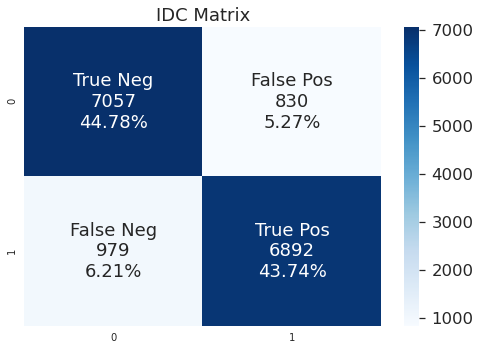

In [31]:
# used https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea for help
#labels = ['True Neg','False Pos','False Neg','True Pos']
#labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax = plt.subplot()
#sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.5)
plt.title('IDC Matrix')

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [ ]:
train_loss = history.history["accuracy"]
test_loss = history.history["val_accuracy"]
plt.figure(figsize = (15,9))


plt.plot(train_loss, label = "InceptionV3 Training Accuracy", color = "navy")
plt.plot(test_loss, label = "InceptonV3 Model Testing Accuracy" , color= "orange")
plt.title("InceptionV3 Classification Model", fontsize = 25)
plt.xlabel("Epoch Count", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.legend();

In [ ]:
# ROC curve graph for InceptionV3
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_classes, pred)

plt.figure(figsize = (15,9))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Resnet50 (area: %0.2f)'
             % auc(fpr,tpr), color = "purple")
plt.xlabel('False positive rate', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.title('ROC for Inception Model', fontsize = 20)
plt.legend(loc='best')
plt.show()

In [ ]:
# save weights from this model
model.save("InceptionV3_model.h5")